In [2]:
import os
import sys
import yaml
import pypsa
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

sys.path.append(str(Path.cwd().parent / "data"))
sys.path.append(str(Path.cwd().parent / "scripts"))
from interconnection_helpers import (
    interconnection_mapper,
    interconnection_capacities,
    interconnection_countries,
    country_coords,
)

from plotting_helpers import (
    plot_merit_order,
    generation_mix_to_ax
)

with open(Path.cwd().parent / 'config.yaml') as f:
    config = yaml.safe_load(f)

    tech_colors = config['tech_colors']
    nice_names = config['nice_names']

In [3]:
bmus_fn = Path.cwd().parent / 'data' / 'preprocessed' / 'prepared_bmus.csv'
cfd_strike_prices_fn = Path.cwd().parent / 'resources' / 'cfd_strike_prices.csv'
roc_values_fn = Path.cwd().parent / 'data' / 'roc_values.csv'
nuclear_marginal_price_fn = Path.cwd().parent / 'data' / 'nuclear_marginal_cost.csv'
battery_phs_capacities_fn = Path.cwd().parent / 'data' / 'battery_phs_capacities.csv'
wholesale_prices_fn = Path.cwd().parent / 'resources' / 'thermal_costs' / '2022-week09.csv'

pn_fn = str(Path.cwd().parent / 'data' / 'base' / '{}' / 'physical_notifications.csv')
mel_fn = str(Path.cwd().parent / 'data' / 'base' / '{}' / 'maximum_export_limits.csv')
dah_fn = str(Path.cwd().parent / 'data' / 'base' / '{}' / 'day_ahead_prices.csv')
europe_wholesale_prices_fn = str(Path.cwd().parent / 'data' / 'base' / '{}' / 'europe_day_ahead_prices.csv')

In [4]:
load_weights_fn = Path.cwd().parent / 'data' / 'preprocessed' / 'load_weights.csv'
network_fn = Path.cwd().parent / 'data' / 'raw' / 'lmp_base.nc'

In [24]:
def scale_merit_order(n, dah, collective=True):
    """
    Scale the marginal cost of fossil and biomass generators by the wholesale price

    if collective is True, the scaling factor is uniform over all network snapshots
    and given by the ratio of the 
        weighted average wholesale price to the
        weighted average marginal_cost of the marginal unit.

    if collective is False, the scaling factor is calculated for each period separately.
    """

    gb_buses = n.buses.loc[n.buses.country == 'GB'].index

    # technologies that see their marginal price scaled by the wholesale price
    scalers = ['fossil', 'biomass']
    scaling_units = n.generators[n.generators.carrier.isin(scalers)].index

    marginal_unit_cost = pd.Series(np.nan, index=n.snapshots)

    for period, dt in enumerate(n.snapshots):

        ints_marginal_cost = []
        ints_marginal_cap = []
        found_countries = []

        for ic, country in interconnection_countries.items():
            try:
                ints_marginal_cost.append(n.generators_t.marginal_cost[country.lower() + "_local_market"].iloc[period])
                ints_marginal_cap.append(n.links.p_nom.loc[ic])
                found_countries.append(country)

            except KeyError:
                continue

        max_avail_gen = pd.concat((
            n.generators.loc[n.generators.bus.isin(gb_buses), ['marginal_cost', 'p_nom', 'carrier']],
            n.storage_units[['marginal_cost', 'p_nom', 'carrier']],
            pd.DataFrame({
                "marginal_cost": ints_marginal_cost,
                'p_nom': ints_marginal_cap,
                'carrier': ['interconnector'] * len(ints_marginal_cost)
                }, index=found_countries)
        ))

        intermittents = n.generators_t.p_max_pu.columns.intersection(max_avail_gen.index)
        max_avail_gen.loc[intermittents, "p_nom"] *= n.generators_t.p_max_pu[intermittents].iloc[period]

        max_avail_gen = max_avail_gen.sort_values(by=['marginal_cost', 'carrier'])

        max_avail_gen['cum_p_nom'] = max_avail_gen['p_nom'].cumsum()

        load = n.loads_t.p_set[gb_buses].iloc[period].sum()
        marginal_unit = max_avail_gen[max_avail_gen['cum_p_nom'] > load].iloc[0].name
        mc = max_avail_gen.loc[marginal_unit, 'marginal_cost']

        marginal_unit_cost.loc[dt] = mc

        if not collective:

            if mc <= 1 or dah.iloc[period, 0] <= 1:
                scaling_factor = 1.
            else:
                scaling_factor = dah.iloc[period, 0] / mc

            new_marginal_cost_units = (
                scaling_units
                .difference(n.generators_t.marginal_cost.columns) 
            )

            n.generators_t.marginal_cost = pd.concat((
                n.generators_t.marginal_cost,
                pd.DataFrame(0., index=n.snapshots, columns=new_marginal_cost_units)
            ), axis=1)

            n.generators_t.marginal_cost.loc[n.snapshots[period], scaling_units] = (
                n.generators.loc[scaling_units, 'marginal_cost'] * scaling_factor
            )
    
    if not collective:
        return

    # calculate the scaling factor
    total_demand = n.loads_t.p_set[gb_buses].sum(axis=1)

    weighted_avg_mc = (marginal_unit_cost * total_demand).sum() / total_demand.sum()
    weighted_avg_dah = (dah.iloc[:, 0] * total_demand).sum() / total_demand.sum()

    if weighted_avg_mc <= 1 or weighted_avg_dah <= 1:
        scaling_factor = 1.
    else:
        scaling_factor = weighted_avg_dah / weighted_avg_mc

    n.generators.loc[scaling_units, 'marginal_cost'] *= scaling_factor



In [6]:
def cleanup_network(n):

    dropgen = n.generators[n.generators.p_nom == 0].index
    print('dropping generators:', dropgen)
    n.generators = n.generators.drop(dropgen)

    for key, item in n.generators_t.items():
        for gen in dropgen:
            try:
                n.generators_t[key] = item.drop(gen, axis=1)
            except KeyError:
                continue


In [26]:
def add_wind(
        n,
        bmus,
        pn,
        mel,
        cfds,
        rocs,
        carrier=None,
    ):

    plants = (
        bmus[bmus['carrier'] == carrier]
        .index
        .intersection(pn.columns)
    )

    print(f'Adding {len(plants)} {carrier} generators...')

    n.add(
        "Generator",
        plants,
        bus=bmus.loc[plants, 'bus'],
        carrier=carrier,
        p_nom=pn[plants].max(),
        marginal_cost=np.nan,
        efficiency=1,
        p_max_pu=pn[plants].div(pn[plants].max()).replace(np.nan, 0),
    )

    roc_generators = rocs.index.intersection(plants)
    n.generators.loc[roc_generators, 'marginal_cost'] = - rocs[roc_generators]

    cfd_generators = cfds.index.intersection(plants)
    n.generators.loc[cfd_generators, 'marginal_cost'] = 0.


def add_onshore_wind(*args):
    add_wind(*args, carrier='onwind')


def add_offshore_wind(*args):
    add_wind(*args, carrier='offwind')


def add_solar(
        n,
        bmus,
        pn,
    ):

    plants = (
        bmus[bmus['carrier'] == 'solar']
        .index
        .intersection(pn.columns)
    )

    print(f'Adding {len(plants)} solar generators...')

    n.add(
        "Generator",
        plants,
        bus=bmus.loc[plants, 'bus'],
        carrier='solar',
        p_nom=pn[plants].max(),
        marginal_cost=0.,
        efficiency=1,
        p_max_pu=pn[plants].div(pn[plants].max()).replace(np.nan, 0),
    )


def add_nuclear(
        n,
        bmus,
        pn,
        nuclear_wholesale_price,
    ):

    plants = bmus[bmus['carrier'] == 'nuclear'].index

    # some nuclear-labelled BMUs always import electricity
    # these are thrown out
    plants = plants.intersection(pn.columns[pn.mean() > 0])

    print(f'Adding {len(plants)} nuclear generators...')
    n.add(
        "Generator",
        plants,
        bus=bmus.loc[plants, 'bus'],
        carrier='nuclear',
        p_nom=pn[plants].max(),
        marginal_cost=nuclear_wholesale_price,
        efficiency=1,
    )

    # For nuclear units that are not constant, a 'p_max_pu' is needed
    for plant in plants:
        if len(pn[plant].unique()) > 1:
            n.generators_t['p_max_pu'].loc[:,plant] = pn[plant].div(pn[plant].max())


def add_thermal(
        n,
        bmus,
        pn,
        mel,
        wholesale_prices,
    ):

    plants = (
        bmus[bmus['carrier'].isin(['biomass', 'fossil'])]
        .index
        .intersection(pn.columns)
        .intersection(mel.columns)
    )
    print(f'Adding {len(plants)} thermal generators...')

    assert plants.isin(wholesale_prices.index).all(), 'Missing wholesale prices for some thermal plants.'    

    n.add(
        "Generator",
        plants,
        bus=bmus.loc[plants, 'bus'],
        carrier=bmus.loc[plants, 'carrier'],
        p_nom=mel[plants].max(),
        marginal_cost=wholesale_prices.loc[plants],
        p_max_pu=mel[plants].div(mel[plants].max()).replace(np.nan, 0),
    )


def add_temporal_flexibility(
        n,
        bmus,
        pn,
        mel,
        battery_phs_capacities,
        carrier='battery',
        ):

    assets = bmus[bmus['carrier'] == carrier].index

    assets = assets.intersection(pn.columns).intersection(mel.columns)

    print(f'Adding {len(assets)} {carrier} storage units...')
    # times two because time step is 30 minutes and max_hours does not
    # refer to hours but time steps within the context of the network's
    # time scale
    max_hours = (
        battery_phs_capacities['energy_cap[MWh]']
        .div(battery_phs_capacities['power_cap[MW]'])
        .mul(2.)
    )

    n.add(
        "StorageUnit",
        assets,
        bus=bmus.loc[assets, 'bus'],
        carrier=carrier,
        p_nom=battery_phs_capacities.loc[assets, 'power_cap[MW]'],
        max_hours=max_hours.loc[assets],
        marginal_cost=0.,
        e_cyclic=True,
        state_of_charge_initial=(
            battery_phs_capacities
            .loc[assets, 'energy_cap[MWh]']
            .div(3.) # start at 1/3 of capacity based on typical overnight charging
        ),
    )


def add_pumped_hydro(*args):
    add_temporal_flexibility(*args, carrier='PHS')


def add_batteries(*args):
    add_temporal_flexibility(*args, carrier='battery')


def add_hydropower(
        n,
        bmus,
        pn,
        roc_values, 
        carrier='hydro',
    ):

    assets = (
        bmus[bmus['carrier'] == carrier]
        .index
        .intersection(pn.columns)
    )

    print(f'Adding {len(assets)} {carrier} generators...')

    if carrier == 'cascade':
        marginal_costs = - roc_values.loc[assets]
    elif carrier == 'hydro':
        marginal_costs = 0.

    n.add(
        "StorageUnit",
        assets,
        bus=bmus.loc[assets, 'bus'],
        carrier=carrier,
        p_nom=pn[assets].max(),
        marginal_cost=marginal_costs,
        e_cyclic=False,
        state_of_charge_initial=pn[assets].sum(),
        max_hours=pn[assets].sum().div(pn[assets].max()),
        p_min_pu=0.,
    )


def add_cascade(*args):
    add_hydropower(*args, carrier='cascade')


def add_dispatchable_hydro(*args):
    add_hydropower(*args, carrier='hydro')
    

def add_interconnectors(
        n,
        bmus,
        pn,
        europe_wholesale_prices,
        interconnection_mapper,
        interconnection_capacities,
        interconnection_countries,
        country_coords,
    ):

    print(f'Adding {len(interconnection_mapper)} interconnectors...')

    # for ic in ['BritNed']: 
    # for ic in ['IFA2']: 
    for (ic, ic_bmunits) in interconnection_mapper.items():

        p_nom = interconnection_capacities[ic]
        country = interconnection_countries[ic]
        marginal_cost = europe_wholesale_prices.loc[:, country]

        # no data for Nemo at the moment
        if ic == 'Nemo':
            link_kwargs = {
                'bus1': '4975'
            }

        else:
            inter_flow = bmus.loc[
                bmus.index.str.contains('|'.join(ic_bmunits)),
                'bus']
            
            if inter_flow.empty:
                print('No interconnector flow data for', ic)
                continue

            gb_bus = inter_flow.value_counts().index[0]

            flow = (
                pn[pn.columns[pn.columns.str.contains('|'.join(ic_bmunits))]]
                .sum(axis=1)
            )

            p_nom = max(p_nom, flow.max())
            link_kwargs = {
                'p_set': flow,
                'bus1': gb_bus,
                }


            if (flow == 0).all():
                print('No interconnector flow data for', ic)
                continue

        # this setup simulates a local market for each country that
        # can either be supplied by local generators (if the local wholesale
        # price is lower than GB wholesale price) or by GB generators
        # via the interconnector (if the GB wholesale price is lower)
        if not country in n.buses.index:
            n.add(
                'Bus',
                country,
                carrier='electricity',
                x=country_coords[country][0],
                y=country_coords[country][1],
                country=country,
                )
            n.add(
                "Load",
                country.lower() + '_local_market',
                bus=country,
                p_set=pd.Series(0, index=pn.index),
                carrier=country,
                )
            n.add(
                "Generator",
                country.lower() + '_local_market',
                bus=country,
                p_nom=0.,
                marginal_cost=marginal_cost,
                carrier="local_market",
                )

        n.add(
            "Link",
            ic,
            bus0=country,
            p_nom=p_nom,
            efficiency=0.99,
            p_max_pu=1.,
            p_min_pu=-1.,
            carrier='interconnector',
            **link_kwargs,
            )

        n.generators.loc[country.lower() + '_local_market', 'p_nom'] += 2 * p_nom
        n.loads_t.p_set.loc[:, country.lower() + '_local_market'] += (
            pd.Series(p_nom, index=pn.index)
        )


def build_static_supply_curve(
        n,
        bmus,
        pn,
        mel,
        wholesale_prices,
        europe_wholesale_prices,
        cfd_strike_prices,
        roc_values,
        nuclear_wholesale_price,
        battery_phs_capacities,
        interconnection_mapper,
        interconnection_capacities,
        interconnection_countries,
        country_coords,
    ):
    """
    Builds one day of available power plants, storage units and their marginal costs.
    It is 'static' in not scaling marginal costs according to wholesale price (yet).
    """

    n.generators.loc[:, 'marginal_cost'] = np.nan
    n.storage_units.loc[:, 'marginal_cost'] = np.nan

    add_onshore_wind(n, bmus, pn, mel, cfd_strike_prices, roc_values)
    add_offshore_wind(n, bmus, pn, mel, cfd_strike_prices, roc_values)
    add_solar(n, bmus, pn)
    add_nuclear(n, bmus, pn, nuclear_wholesale_price)
    add_thermal(n, bmus, pn, mel, wholesale_prices)
    add_batteries(n, bmus, pn, mel, battery_phs_capacities)
    add_pumped_hydro(n, bmus, pn, mel, battery_phs_capacities)
    add_cascade(n, bmus, pn, roc_values)
    add_dispatchable_hydro(n, bmus, pn, roc_values)
    add_interconnectors(
        n,
        bmus,
        pn,
        europe_wholesale_prices,
        interconnection_mapper,
        interconnection_capacities,
        interconnection_countries,
        country_coords,
        )

    print('')


def add_load(n, pns, weights):

    # subtract for interconnector export
    real_int_flow = pd.DataFrame(index=n.snapshots)

    for name, bmu_names in interconnection_mapper.items():
        if name == 'Nemo':
            continue

        real_int_flow[name] = (
            pn[pn.columns[pn.columns.str.contains('|'.join(bmu_names))]]
            .sum(axis=1)
        )
    export = real_int_flow.clip(upper=0).sum(axis=1).mul(-1)

    assert (export >= 0).all(), 'Interconnector export should be negative.'

    # subtract charging of temporal flexibility assets
    storages = n.storage_units.index.intersection(pns.columns)
    charging = pns[storages].clip(upper=0).sum(axis=1).mul(-1)

    assert (charging >= 0).all(), 'Charging should be negative.'

    net_load = pn.clip(lower=0).sum(axis=1) - export - charging

    print('Adding load...')

    p_set = pd.DataFrame(
        np.outer(net_load, weights['load_weight']),
        index=n.snapshots,
        columns=weights.index
        )

    n.add(
        "Load",
        weights.index,
        bus=weights.index,
        p_set=p_set,
        carrier='electricity',
    )


def add_carriers(n, bmus, interconnection_countries):
    n.add("Carrier", bmus['carrier'].unique())
    n.add("Carrier", "load")
    n.add("Carrier", "electricity")
    n.add("Carrier", "local_market")
    n.add("Carrier", list(set(interconnection_countries.values())))


if __name__ == '__main__':

    day = '2022-02-28'

    pn = pd.read_csv(pn_fn.format(day), index_col=0, parse_dates=True)
    mel = pd.read_csv(mel_fn.format(day), index_col=0, parse_dates=True)
    dah = pd.read_csv(dah_fn.format(day), index_col=0, parse_dates=True)
    europe_wholesale_prices = pd.read_csv(europe_wholesale_prices_fn.format(day), index_col=0, parse_dates=True)

    pn.index = pn.index.values
    mel.index = mel.index.values
    europe_wholesale_prices.index = europe_wholesale_prices.index.values
    dah.index = dah.index.values

    wholesale_prices = (
        pd.read_csv(wholesale_prices_fn, index_col=0)
        .iloc[:,0]
    )

    cfd_strike_prices = (
        pd.read_csv(cfd_strike_prices_fn, index_col=0, parse_dates=True)
        .loc[:, :day]
        .iloc[:, -1]
        .rename('cfd_strike_price')
    )

    roc_values_fn = Path.cwd().parent / 'data' / 'roc_values.csv'
    roc_values = (
        pd.read_csv(roc_values_fn, index_col=0)
        .iloc[:,0]
        .rename('roc_value')
    )

    nuclear_wholesale_price = pd.read_csv(nuclear_marginal_price_fn, index_col=0).iloc[0,0]
    battery_phs_capacities = pd.read_csv(battery_phs_capacities_fn, index_col=0)

    # n = pypsa.Network()
    n = pypsa.Network(network_fn)
    weights = pd.read_csv(load_weights_fn, index_col=0)
    weights.index = weights.index.astype(str)

    bmus = pd.read_csv(bmus_fn, index_col=0)
    bmus['bus'] = bmus['bus'].astype(str)

    add_carriers(n, bmus, interconnection_countries)

    n.set_snapshots(pn.index)

    add_load(n, pn, weights)

    build_static_supply_curve(
        n,
        bmus,
        pn,
        mel,
        wholesale_prices,
        europe_wholesale_prices,
        cfd_strike_prices,
        roc_values,
        nuclear_wholesale_price,
        battery_phs_capacities,
        interconnection_mapper,
        interconnection_capacities,
        interconnection_countries,
        country_coords,
        )

    # cleanup_network(n) 

    m = n.generators_t.marginal_cost 

    scale_merit_order(n, dah, collective=True)

    # n.links['p_nom'] *= 0.1

C:\Users\lukas\AppData\Local\Temp\ipykernel_28740\239772413.py:439: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.read_csv(cfd_strike_prices_fn, index_col=0, parse_dates=True)
INFO:pypsa.io:Imported network lmp_base.nc has buses, lines, links, transformers


Adding load...
Adding 97 onwind generators...
Adding 68 offwind generators...
Adding 0 solar generators...
Adding 10 nuclear generators...
Adding 106 thermal generators...
Adding 27 battery storage units...
Adding 17 PHS storage units...
Adding 7 cascade generators...
Adding 18 hydro generators...
Adding 9 interconnectors...
No interconnector flow data for EastWest
No interconnector flow data for Moyle
No interconnector flow data for Viking



c:\Users\lukas\miniforge3\envs\pypsa-eur\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


(<matplotlib.collections.PatchCollection at 0x287107c1e80>,
 <matplotlib.collections.LineCollection at 0x2871062f380>)

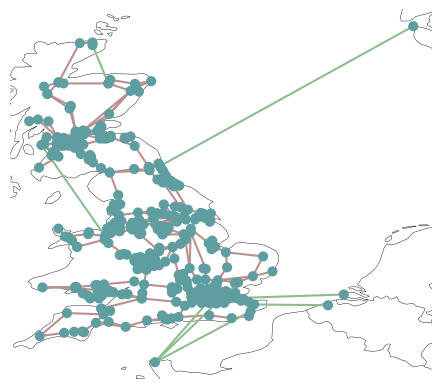

In [27]:
n.plot()

In [28]:
print(n)

PyPSA Network 'PyPSA-Eur'
Components:
 - Bus: 389
 - Carrier: 21
 - Generator: 285
 - Line: 460
 - Link: 9
 - Load: 389
 - StorageUnit: 69
 - Transformer: 55
Snapshots: 48


In [29]:
n.optimize()

Index(['8009', '8708', '8706'], dtype='object', name='Link')
Index(['15756', '15757', '15758', '15787', '15788', '15789', '15790', '15791',
       '15792', '15793', '15794', '15795', '15796', '15797', '15798', '15799',
       '15800', '15910', '15911', '15912', '15913', '15914', '15915', '15916',
       '15917', '15918', '15919', '15920', '15921', '15922', '15923', '15924',
       '15925', '15926', '15927', '15928', '15929', '15930', '15931', '15932',
       '15933', '15934', '15935', '15936', '15937', '15938', '15939', '15940',
       '16000', '16001', '16002', '16003', '16004', '16005', '16006'],
      dtype='object', name='Transformer')
Index(['8838', '8013', '8520', '8649', '4950', '4951', '4952', '4953', '4954',
       '4955',
       ...
       '8578', '7469', '8027', '8016', '8019', '7458', '8283', '8094', '8093',
       '7908'],
      dtype='object', name='Bus', length=385)
Index(['11524', '8702', '8704', '8703', '14745', '2144', '6084', '6125',
       '11733', '11729',
       .

('ok', 'optimal')

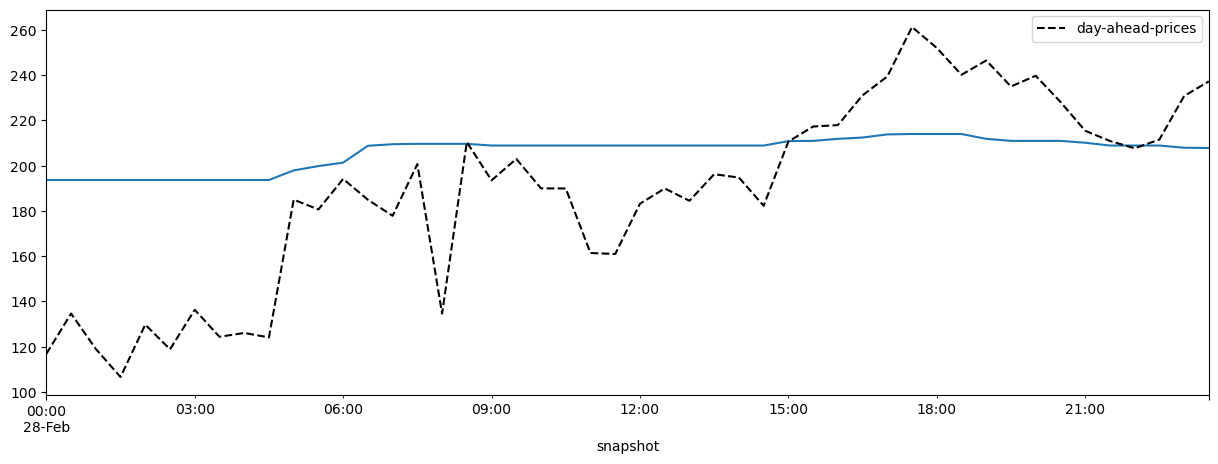

In [30]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 5))
# n.buses_t.marginal_price.drop(columns='bus').plot(ax=ax)
n.buses_t.marginal_price.iloc[:,0].plot(ax=ax)
dah.plot(ax=ax, color='black', linestyle='--')

plt.show()

In [31]:
n.generators.loc[n.generators.bus != 'bus']

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
CMSTW-1,6443,Slack,,47.0,0.0,False,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,47.0
ROTHW-1,6448,PQ,,50.0,0.0,False,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,50.0
PAUHW-1,6448,PQ,,60.0,0.0,False,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,60.0
CAIRW-2,6448,PQ,,41.5,0.0,False,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,41.5
MDHLW-1,6486,PQ,,76.0,0.0,False,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,76.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SHBA-2,6043,PQ,,269.0,0.0,False,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,269.0
netherlands_local_market,Netherlands,PQ,,2542.0,0.0,False,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,2542.0
france_local_market,France,PQ,,9800.0,0.0,False,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,9800.0


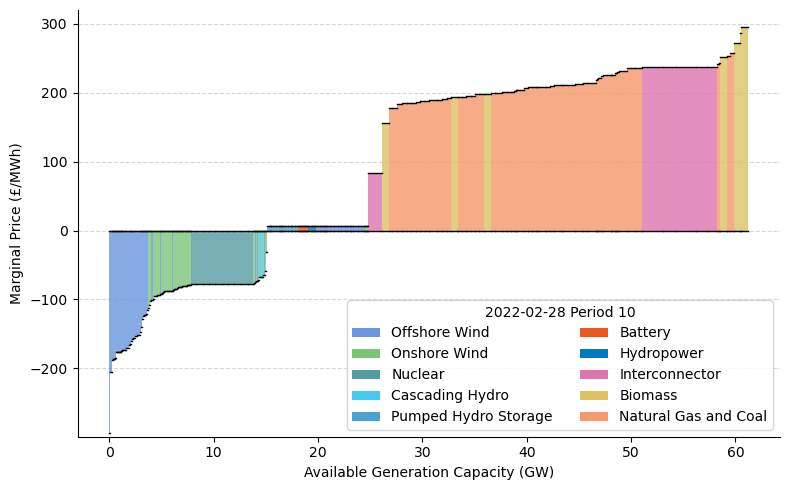

In [32]:
plot_merit_order(n, 10)

In [33]:
real_totals = pd.DataFrame(index=n.snapshots)

for carrier in n.generators.carrier.unique():
    if carrier == 'local_market':
        continue
    real_totals[carrier] = pn[n.generators[n.generators.carrier == carrier].index].sum(axis=1)

for carrier in n.storage_units.carrier.unique():
    real_totals[carrier] = pn[n.storage_units[n.storage_units.carrier == carrier].index].sum(axis=1)

real_int_flow = pd.DataFrame(index=n.snapshots)

interconnector_bmus = []

for name, bmu_names in interconnection_mapper.items():
    if name == 'Nemo':
        continue

    current_bmus = pn.columns[pn.columns.str.contains('|'.join(bmu_names))]
    interconnector_bmus.extend(current_bmus)
    real_int_flow[name] = pn[current_bmus].sum(axis=1)

real_totals['interconnector'] = real_int_flow.sum(axis=1)
real_totals = real_totals.T.loc[pd.Index(list(tech_colors)).intersection(real_totals.T.index)].mul(1e-3)

<Axes: xlabel='snapshot'>

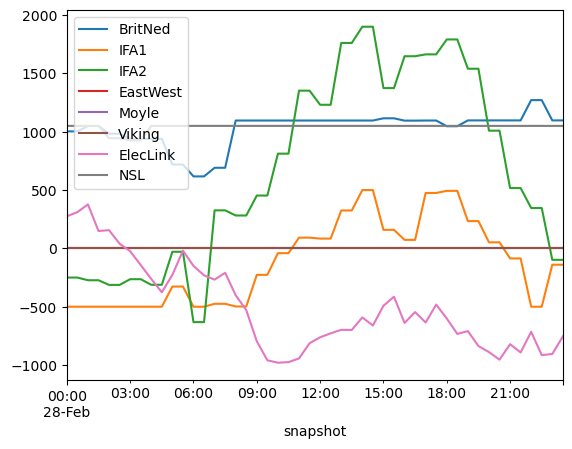

In [34]:
real_int_flow.plot()

In [35]:
idx = pd.IndexSlice

totals = n.statistics.energy_balance(
    comps=['Generator', 'StorageUnit'],
    aggregate_time=False,
)
inter_totals = pd.DataFrame({
    'hold': 
        (l := n.links_t.p0)
        [l.columns.intersection(list(interconnection_mapper))]
        .sum(axis=1)
        },
).T

inter_totals.index = pd.MultiIndex.from_product([('Link',), ('interconnector',), ('electricity',)])

totals = pd.concat((
    totals,
    inter_totals
), axis=0)

totals = (
    totals
    .loc[totals.index.get_level_values(1).isin(list(tech_colors))]
    .droplevel([0,2])
    .mul(1e-3)
)

totals = totals.loc[pd.Index(list(tech_colors)).intersection(totals.index)]

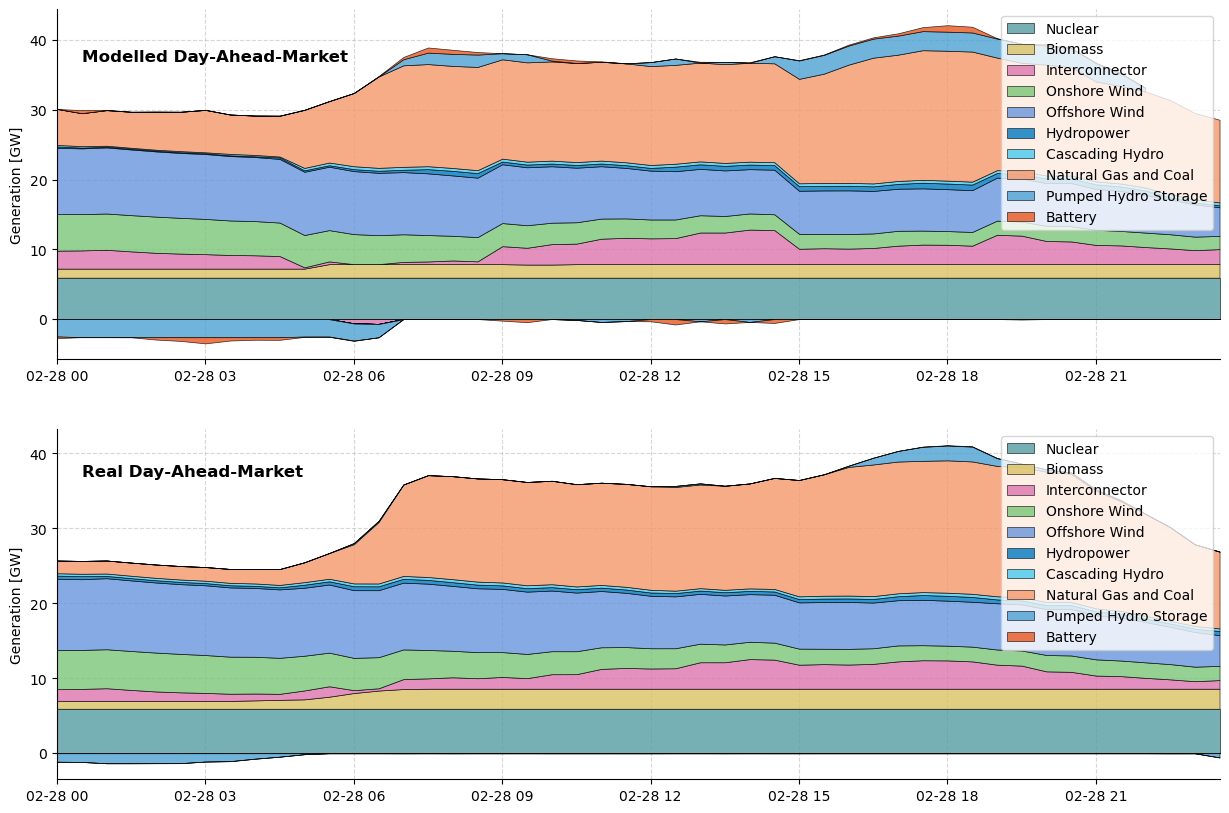

In [36]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

generation_mix_to_ax(axs[0], totals, tech_colors, nice_names)
generation_mix_to_ax(axs[1], real_totals, tech_colors, nice_names)

axs[0].text(n.snapshots[1], 37, 'Modelled Day-Ahead-Market', fontsize=12, fontweight='bold')
axs[1].text(n.snapshots[1], 37, 'Real Day-Ahead-Market', fontsize=12, fontweight='bold')

plt.show()

In [ ]:
n1 = pypsa.Network()

n1.add("Bus", "bus1")
n1.add("Bus", "bus2")

n1.add("Generator", "gen1", bus="bus1", p_nom=1, marginal_cost=10)

TypeError: Network.add() missing 2 required positional arguments: 'class_name' and 'name'

In [11]:
totals.loc['interconnector']
ints = n.links.loc[n.links.carrier == 'interconnector'].index
# ints = [i for i in ints if interconnection_countries[i] in ['Norway', 'Ireland']]

print(ints)

fig, ax = plt.subplots(figsize=(15, 5))
# n.links_t.p0[ints.drop("Nemo")].plot(ax=ax)
n.links_t.p0[ints].plot(ax=ax)

NameError: name 'totals' is not defined

In [10]:
real_int_flow = pd.DataFrame(index=n.links_t.p0[ints].index)

for name, bmu_names in interconnection_mapper.items():

    if not interconnection_countries[name] in ['Norway', 'Ireland']:
        continue

    if name == 'Nemo':
        continue
    real_int_flow[name] = pn[pn.columns[pn.columns.str.contains('|'.join(bmu_names))]].sum(axis=1)

fig, ax = plt.subplots(figsize=(15, 5))
real_int_flow.plot(ax=ax)

NameError: name 'ints' is not defined

In [178]:
period = 0
plot_merit_order(n, period)

['p_min_pu', 'p_max_pu', 'p_set', 'q_set', 'spill_cost', 'marginal_cost', 'marginal_cost_quadratic', 'marginal_cost_storage', 'state_of_charge_set', 'efficiency_store', 'efficiency_dispatch', 'standing_loss', 'inflow', 'p', 'p_dispatch', 'p_store', 'q', 'state_of_charge', 'spill', 'mu_upper', 'mu_lower', 'mu_state_of_charge_set', 'mu_energy_balance']


In [179]:


for period in range(len(n.snapshots)):
    scale_merit_order(n, dah, period)

# scale_merit_order(n, dah, 0)


In [180]:
for period in [12, 24, 36]:
    plot_merit_order(n, period)

['p_min_pu', 'p_max_pu', 'p_set', 'q_set', 'spill_cost', 'marginal_cost', 'marginal_cost_quadratic', 'marginal_cost_storage', 'state_of_charge_set', 'efficiency_store', 'efficiency_dispatch', 'standing_loss', 'inflow', 'p', 'p_dispatch', 'p_store', 'q', 'state_of_charge', 'spill', 'mu_upper', 'mu_lower', 'mu_state_of_charge_set', 'mu_energy_balance']
['p_min_pu', 'p_max_pu', 'p_set', 'q_set', 'spill_cost', 'marginal_cost', 'marginal_cost_quadratic', 'marginal_cost_storage', 'state_of_charge_set', 'efficiency_store', 'efficiency_dispatch', 'standing_loss', 'inflow', 'p', 'p_dispatch', 'p_store', 'q', 'state_of_charge', 'spill', 'mu_upper', 'mu_lower', 'mu_state_of_charge_set', 'mu_energy_balance']
['p_min_pu', 'p_max_pu', 'p_set', 'q_set', 'spill_cost', 'marginal_cost', 'marginal_cost_quadratic', 'marginal_cost_storage', 'state_of_charge_set', 'efficiency_store', 'efficiency_dispatch', 'standing_loss', 'inflow', 'p', 'p_dispatch', 'p_store', 'q', 'state_of_charge', 'spill', 'mu_upper', 

In [188]:
import pypsa

n = pypsa.Network()

n.set_snapshots(list(range(6)))

n.add("Carrier", "electricity")
n.add("Carrier", "gas")

n.add("Bus", "bus", carrier="electricity")
n.add("Load", "load", bus="bus", p_set=1)
n.add("Generator", "gas", bus="bus", carrier="gas", p_nom=1, marginal_cost=1)
n.add("Generator", "oil", bus="bus", carrier="oil", p_nom=1, marginal_cost=3)


print(n.generators_t["marginal_cost"])
n.generators_t["marginal_cost"] = pd.concat((
    n.generators_t["marginal_cost"],
    pd.DataFrame(10, index=n.snapshots, columns=['gas']),
), axis=1)

print(n.generators[['marginal_cost']])
print(n.generators_t.marginal_cost)

n.optimize()

Index(['oil'], dtype='object', name='Generator')
Index(['oil'], dtype='object', name='Generator')


Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5]
           marginal_cost
Generator               
gas                  1.0
oil                  3.0
          gas
snapshot     
0          10
1          10
2          10
3          10
4          10
5          10


c:\Users\lukas\miniforge3\envs\pypsa-eur\Lib\site-packages\linopy\common.py:147: UserWarning: coords for dimension(s) ['Generator'] is not aligned with the pandas object. Previously, the indexes of the pandas were ignored and overwritten in these cases. Now, the pandas object's coordinates are taken considered for alignment.
  warn(
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.02s
INFO:linopy.solvers:Log file at C:\Users\lukas\AppData\Local\Temp\highs.log
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 12 primals, 32 duals
Objective: 1.80e+01
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper were not assigned to the network.


('ok', 'optimal')

In [74]:
dah.iloc[36]

day-ahead-prices    252.07
Name: 2022-02-28 18:00:00+00:00, dtype: float64

In [53]:
# n.storage_units.loc[n.storage_units.carrier == 'battery']
n.generators.loc[n.generators.carrier == 'offwind']

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,


In [235]:
def plot_power_flow(n, colours, nice_names):

    summed_generation = []
    carrz = []

    for carrier in n.generators.carrier.unique():
        carrz.append(carrier)
        summed_generation.append(
            n.generators_t.p[
                n.generators.loc[n.generators.carrier == carrier].index]
                .sum(axis=1))

    for carrier in n.storage_units.carrier.unique():
        carrz.append(carrier)
        summed_generation.append(
            n.storage_units_t.p[
                n.storage_units.loc[n.storage_units.carrier == carrier].index]
                .sum(axis=1))

    return summed_generation, carrz

summed_generation, carrz = plot_power_flow(n, tech_colors, nice_names)

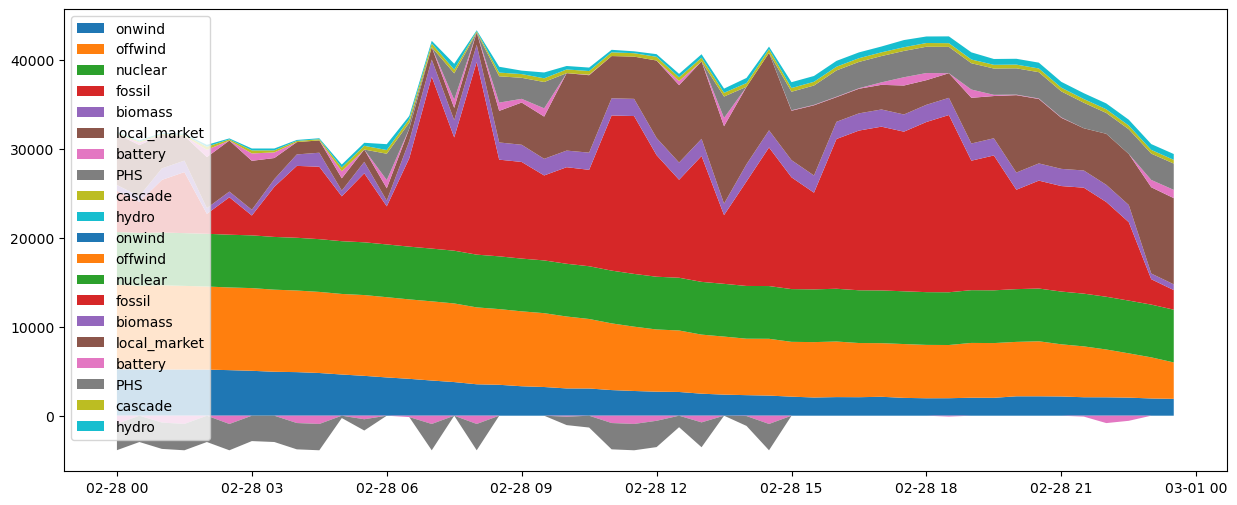

In [236]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(15, 6))

pos = pd.concat(summed_generation, axis=1).clip(lower=0)
neg = pd.concat(summed_generation, axis=1).clip(upper=0)

ax.stackplot(
    summed_generation[0].index,
    *[pos[c] for c in pos.columns],
    labels=carrz,
)
ax.stackplot(
    summed_generation[0].index,
    *[neg[c] for c in pos.columns],
    labels=carrz,
)
ax.legend(loc='upper left')



In [ ]:
def add_demand(n, bmus, pn, mel):

    loads = bmus[bmus['carrier'] == 'demand'].index.intersection(pn.columns)

    print(f'Adding {len(loads)} demand loads...')

    n.add(
        "Load",
        loads,
        bus='bus',
        p_set=pn[loads],
    )

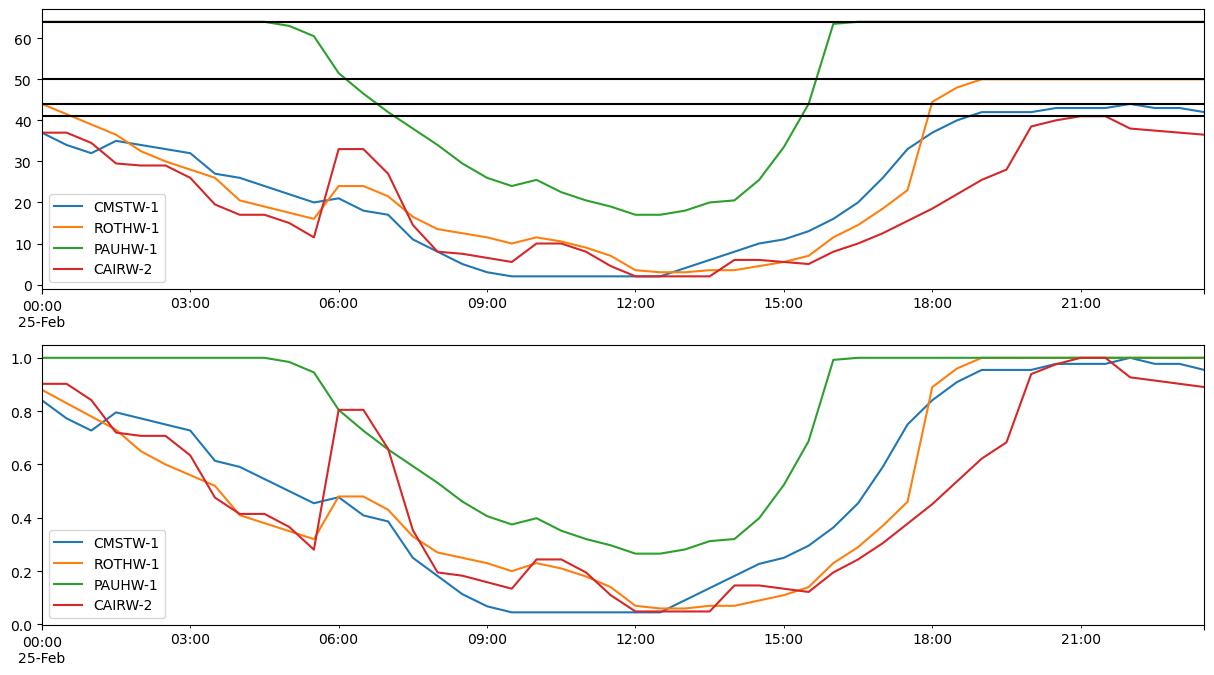

In [32]:
import matplotlib.pyplot as plt

onshore = bmus[bmus['carrier'] == 'onwind'].index.intersection(pn.columns).intersection(mel.columns)[:4]

fig, axs = plt.subplots(2, 1, figsize=(15, 8))

pn.loc[:, onshore].plot(ax=axs[0])
for i in onshore:
    axs[0].axhline(pn[i].max(), color='black')

normalised_pn = pn[onshore].div(pn[onshore].max())
normalised_pn.loc[:, onshore].plot(ax=axs[1])

plt.show()

In [33]:
normalised_pn

,CMSTW-1,ROTHW-1,PAUHW-1,CAIRW-2
2022-02-25 00:00:00,0.840909,0.88,1.000000,0.902439
2022-02-25 00:30:00,0.772727,0.83,1.000000,0.902439
2022-02-25 01:00:00,0.727273,0.78,1.000000,0.841463
2022-02-25 01:30:00,0.795455,0.73,1.000000,0.719512
2022-02-25 02:00:00,0.772727,0.65,1.000000,0.707317
2022-02-25 02:30:00,0.750000,0.60,1.000000,0.707317
2022-02-25 03:00:00,0.727273,0.56,1.000000,0.634146
2022-02-25 03:30:00,0.613636,0.52,1.000000,0.475610
2022-02-25 04:00:00,0.590909,0.41,1.000000,0.414634
2022-02-25 04:30:00,0.545455,0.38,1.000000,0.414634
